# Notebook de comparaison ARI

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv('data/clean.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94269 entries, 0 to 94268
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         94269 non-null  object 
 1   total_orders               94269 non-null  int64  
 2   avg_delivery_time_days     94269 non-null  float64
 3   days_since_last_order      94269 non-null  float64
 4   total_spent                94269 non-null  float64
 5   avg_review_score           94269 non-null  float64
 6   max_delivery_delay_days    94269 non-null  float64
 7   has_comment                94269 non-null  int64  
 8   last_payment_type          94269 non-null  object 
 9   last_payment_installments  94269 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 7.2+ MB


In [3]:
df_degraded = df.copy()

# On prend le plus petit "days_since_last_order" du dataset
min_days_since_last_order = df_degraded['days_since_last_order'].min()

# On calcule la valeur correspondant à un an avant la commande la plus récente
one_year_ago = min_days_since_last_order + 365
six_month_ago = min_days_since_last_order + 180
three_month_ago = min_days_since_last_order + 90
two_month_ago = min_days_since_last_order + 60

# On filtre le dataframe pour garder seulement les lignes où days_since_last_order est supérieur à one_year_ago
df_degraded = df_degraded[df_degraded['days_since_last_order'] > one_year_ago]

# Réinitialiser l'index si nécessaire
df_degraded = df_degraded.reset_index(drop=True)

df_degraded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21193 entries, 0 to 21192
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         21193 non-null  object 
 1   total_orders               21193 non-null  int64  
 2   avg_delivery_time_days     21193 non-null  float64
 3   days_since_last_order      21193 non-null  float64
 4   total_spent                21193 non-null  float64
 5   avg_review_score           21193 non-null  float64
 6   max_delivery_delay_days    21193 non-null  float64
 7   has_comment                21193 non-null  int64  
 8   last_payment_type          21193 non-null  object 
 9   last_payment_installments  21193 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.6+ MB


In [4]:
numeric_features = ['total_orders', 'avg_delivery_time_days', 'days_since_last_order', 
                    'total_spent', 'avg_review_score', 
                    'max_delivery_delay_days', 'has_comment', 'last_payment_installments']

In [5]:
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[numeric_features]), 
                             columns=[f"{col}_normalized" for col in numeric_features])

# Combinaison des données normalisées avec le dataframe original
df = pd.concat([df.reset_index(drop=True), df_normalized], axis=1)

In [6]:
features_optimal = [col for col in df.columns if col.endswith('_normalized')]
X_optimal = df[features_optimal]

In [7]:
kmeans_optimal = KMeans(n_clusters=6, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(X_optimal)

In [8]:
# df_degraded = df.copy()

In [9]:
df_degraded_normalized = pd.DataFrame(scaler.transform(df_degraded[numeric_features]), 
                                      columns=[f"{col}_normalized" for col in numeric_features])
df_degraded = pd.concat([df_degraded.reset_index(drop=True), df_degraded_normalized], axis=1)

In [10]:
X_degraded = df_degraded[features_optimal]
kmeans_degraded = KMeans(n_clusters=6, random_state=42)
clusters_degraded = kmeans_degraded.fit_predict(X_degraded)

In [11]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Assurez-vous que ces variables sont correctement définies
# features_optimal, X_optimal, numeric_features, scaler

# Création des clusters optimaux sur l'ensemble complet
kmeans_optimal = KMeans(n_clusters=6, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(X_optimal)

# Ajout des clusters optimaux au DataFrame original
df['cluster_optimal'] = clusters_optimal

# Création du sous-ensemble dégradé
one_year_ago = df['days_since_last_order'].min() + 365
df_degraded = df[df['days_since_last_order'] > one_year_ago].copy()

# Normalisation et préparation des données dégradées
df_degraded_normalized = pd.DataFrame(scaler.transform(df_degraded[numeric_features]),
                                      columns=[f"{col}_normalized" for col in numeric_features])
df_degraded = pd.concat([df_degraded.reset_index(drop=True), df_degraded_normalized], axis=1)

X_degraded = df_degraded[features_optimal]

# Création des clusters dégradés
kmeans_degraded = KMeans(n_clusters=6, random_state=42)
clusters_degraded = kmeans_degraded.fit_predict(X_degraded)

# Ajout des clusters dégradés au DataFrame dégradé
df_degraded['cluster_degraded'] = clusters_degraded

# Sélection des mêmes clients dans les deux DataFrames
common_customers = set(df_degraded['customer_unique_id']) & set(df['customer_unique_id'])

# Filtrer les deux DataFrames pour n'inclure que les clients communs
df_optimal_subset = df[df['customer_unique_id'].isin(common_customers)].copy()
df_degraded_subset = df_degraded[df_degraded['customer_unique_id'].isin(common_customers)].copy()

# Dédoublonnage des DataFrames en gardant la dernière occurrence
df_optimal_subset = df_optimal_subset.drop_duplicates(subset='customer_unique_id', keep='last')
df_degraded_subset = df_degraded_subset.drop_duplicates(subset='customer_unique_id', keep='last')

# Tri des DataFrames par customer_unique_id pour s'assurer de l'alignement
df_optimal_subset = df_optimal_subset.sort_values('customer_unique_id').reset_index(drop=True)
df_degraded_subset = df_degraded_subset.sort_values('customer_unique_id').reset_index(drop=True)

# Extraction des clusters pour les mêmes clients
clusters_optimal_subset = df_optimal_subset['cluster_optimal'].values
clusters_degraded_subset = df_degraded_subset['cluster_degraded'].values

# Calcul du score ARI
ari_score = adjusted_rand_score(clusters_optimal_subset, clusters_degraded_subset)
print(f"\nScore ARI entre le modèle optimal et le modèle dégradé : {ari_score}")

# Calcul du pourcentage de clients ayant changé de cluster
changed_clusters = (clusters_optimal_subset != clusters_degraded_subset).sum()
total_clients = len(clusters_optimal_subset)
percentage_changed = (changed_clusters / total_clients) * 100

print(f"\nPourcentage de clients ayant changé de cluster : {percentage_changed:.2f}%")

# Analyse des changements de cluster
df_comparison = pd.DataFrame({
    'customer_unique_id': df_optimal_subset['customer_unique_id'],
    'cluster_optimal': clusters_optimal_subset,
    'cluster_degraded': clusters_degraded_subset,
    'changed': clusters_optimal_subset != clusters_degraded_subset
})

# Affichage des premiers résultats
print("\nAperçu des changements de cluster :")
print(df_comparison.head(10))

# Analyse des caractéristiques des clients ayant changé de cluster
changed_customers = df_comparison[df_comparison['changed']]
unchanged_customers = df_comparison[~df_comparison['changed']]

print("\nAnalyse des caractéristiques des clients ayant changé de cluster :")
for feature in features_optimal:
    changed_mean = df_degraded_subset[df_degraded_subset['customer_unique_id'].isin(changed_customers['customer_unique_id'])][feature].mean()
    unchanged_mean = df_degraded_subset[df_degraded_subset['customer_unique_id'].isin(unchanged_customers['customer_unique_id'])][feature].mean()
    
    print(f"\nMoyenne de {feature} :")
    print(f"Clients ayant changé de cluster : {changed_mean}")
    print(f"Clients n'ayant pas changé de cluster : {unchanged_mean}")


Score ARI entre le modèle optimal et le modèle dégradé : 0.6637437089726498

Pourcentage de clients ayant changé de cluster : 33.12%

Aperçu des changements de cluster :
                 customer_unique_id  cluster_optimal  cluster_degraded  \
0  0000f46a3911fa3c0805444483337064                2                 4   
1  0005e1862207bf6ccc02e4228effd9a0                0                 0   
2  0006fdc98a402fceb4eb0ee528f6a8d4                1                 3   
3  000a5ad9c4601d2bbdd9ed765d5213b3                0                 0   
4  000de6019bb59f34c099a907c151d855                1                 3   
5  0010a452c6d13139e50b57f19f52e04e                1                 3   
6  00115fc7123b5310cf6d3a3aa932699e                0                 0   
7  0011805441c0d1b68b48002f1d005526                2                 4   
8  0011857aff0e5871ce5eb429f21cdaf5                0                 0   
9  0011c98589159d6149979563c504cb21                0                 4   

   changed  
0

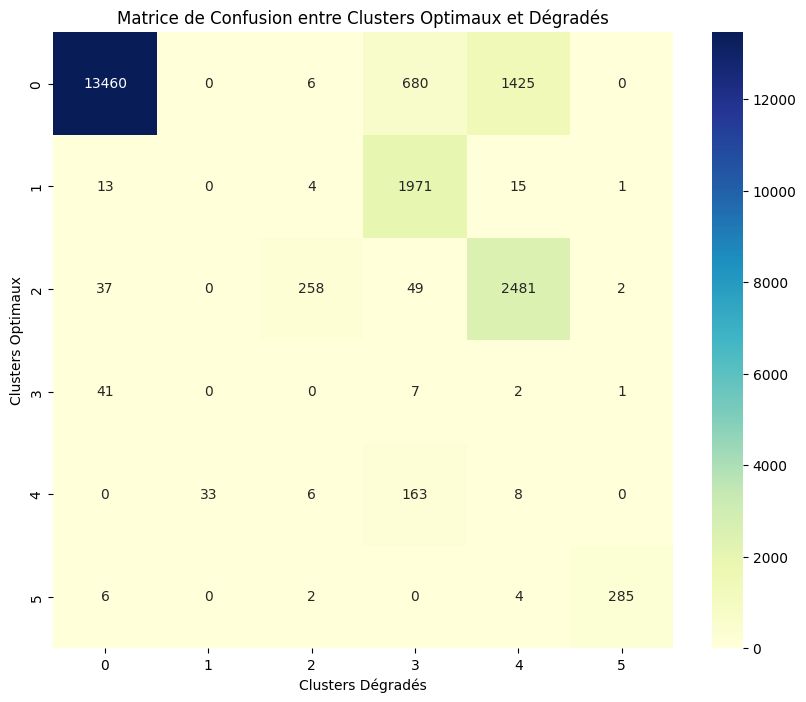


Pourcentage de clients ayant changé de cluster : 33.12%

Moyenne de total_orders_normalized :
Clients ayant changé de cluster : -0.1052
Clients n'ayant pas changé de cluster : 0.0387

Moyenne de avg_delivery_time_days_normalized :
Clients ayant changé de cluster : 0.2412
Clients n'ayant pas changé de cluster : -0.1614

Moyenne de days_since_last_order_normalized :
Clients ayant changé de cluster : 1.4452
Clients n'ayant pas changé de cluster : 1.4561

Moyenne de total_spent_normalized :
Clients ayant changé de cluster : 0.1546
Clients n'ayant pas changé de cluster : -0.0855

Moyenne de avg_review_score_normalized :
Clients ayant changé de cluster : -0.5872
Clients n'ayant pas changé de cluster : 0.3747

Moyenne de max_delivery_delay_days_normalized :
Clients ayant changé de cluster : 0.1464
Clients n'ayant pas changé de cluster : -0.1496

Moyenne de has_comment_normalized :
Clients ayant changé de cluster : 0.3851
Clients n'ayant pas changé de cluster : -0.1502

Moyenne de last_paymen

In [12]:
# Création de la matrice de confusion
confusion_matrix = pd.crosstab(df_optimal_subset['cluster_optimal'], 
                               df_degraded_subset['cluster_degraded'],
                               rownames=['Clusters Optimaux'],
                               colnames=['Clusters Dégradés'])

# Tracé de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Matrice de Confusion entre Clusters Optimaux et Dégradés')
plt.show()

# Calcul du pourcentage de clients ayant changé de cluster
df_comparison = df_optimal_subset.copy()
df_comparison['cluster_degraded'] = df_degraded_subset['cluster_degraded']
df_comparison['cluster_changed'] = df_comparison['cluster_optimal'] != df_comparison['cluster_degraded']
percentage_changed = df_comparison['cluster_changed'].mean() * 100

print(f"\nPourcentage de clients ayant changé de cluster : {percentage_changed:.2f}%")

# Analyse des caractéristiques des clients ayant changé de cluster
changed_clusters = df_comparison[df_comparison['cluster_changed']]
unchanged_clusters = df_comparison[~df_comparison['cluster_changed']]

for feature in features_optimal:
    print(f"\nMoyenne de {feature} :")
    print(f"Clients ayant changé de cluster : {changed_clusters[feature].mean():.4f}")
    print(f"Clients n'ayant pas changé de cluster : {unchanged_clusters[feature].mean():.4f}")

In [13]:
# Assurez-vous que df_optimal_subset et df_degraded_subset sont correctement définis auparavant
df_comparison = df_optimal_subset.copy()
df_comparison['cluster_degraded'] = df_degraded_subset['cluster_degraded']
df_comparison['cluster_changed'] = df_comparison['cluster_optimal'] != df_comparison['cluster_degraded']

print("\nPourcentage de clients ayant changé de cluster :")
print(df_comparison['cluster_changed'].mean() * 100)


Pourcentage de clients ayant changé de cluster :
33.12022900763359


In [14]:
changed_clusters = df_comparison[df_comparison['cluster_changed']]
unchanged_clusters = df_comparison[~df_comparison['cluster_changed']]

for feature in features_optimal:
    print(f"\nMoyenne de {feature} :")
    print(f"Clients ayant changé de cluster : {changed_clusters[feature].mean():.4f}")
    print(f"Clients n'ayant pas changé de cluster : {unchanged_clusters[feature].mean():.4f}")


Moyenne de total_orders_normalized :
Clients ayant changé de cluster : -0.1052
Clients n'ayant pas changé de cluster : 0.0387

Moyenne de avg_delivery_time_days_normalized :
Clients ayant changé de cluster : 0.2412
Clients n'ayant pas changé de cluster : -0.1614

Moyenne de days_since_last_order_normalized :
Clients ayant changé de cluster : 1.4452
Clients n'ayant pas changé de cluster : 1.4561

Moyenne de total_spent_normalized :
Clients ayant changé de cluster : 0.1546
Clients n'ayant pas changé de cluster : -0.0855

Moyenne de avg_review_score_normalized :
Clients ayant changé de cluster : -0.5872
Clients n'ayant pas changé de cluster : 0.3747

Moyenne de max_delivery_delay_days_normalized :
Clients ayant changé de cluster : 0.1464
Clients n'ayant pas changé de cluster : -0.1496

Moyenne de has_comment_normalized :
Clients ayant changé de cluster : 0.3851
Clients n'ayant pas changé de cluster : -0.1502

Moyenne de last_payment_installments_normalized :
Clients ayant changé de clust


Période : 365 jours
Score ARI : 0.6637
Pourcentage de clients ayant changé de cluster : 33.12%

Période : 180 jours
Score ARI : 0.3588
Pourcentage de clients ayant changé de cluster : 56.53%

Période : 90 jours
Score ARI : 0.3525
Pourcentage de clients ayant changé de cluster : 61.69%

Période : 60 jours
Score ARI : 0.3549
Pourcentage de clients ayant changé de cluster : 96.06%


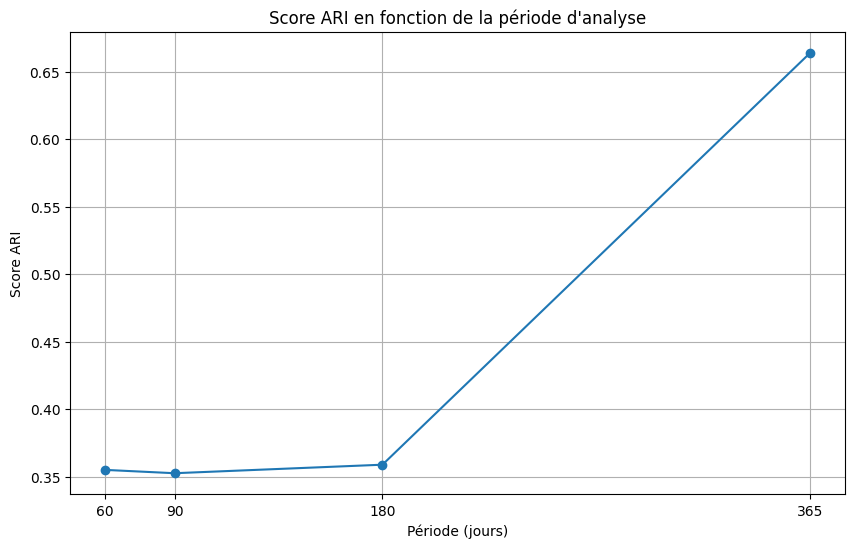

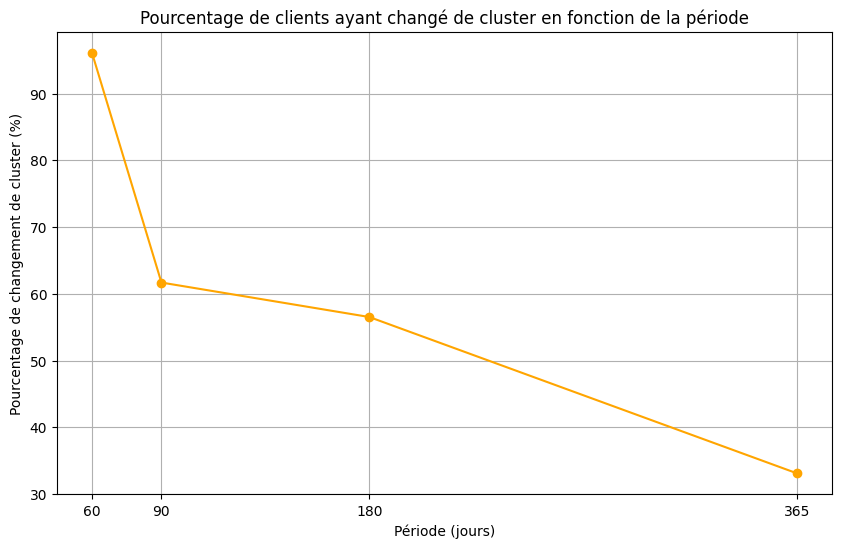

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv('data/clean.csv')

# Sélection des features numériques
numeric_features = ['total_orders', 'avg_delivery_time_days', 'days_since_last_order', 
                    'total_spent', 'avg_review_score', 
                    'max_delivery_delay_days', 'has_comment', 'last_payment_installments']

# Normalisation des données
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[numeric_features]), 
                             columns=[f"{col}_normalized" for col in numeric_features])

# Combinaison des données normalisées avec le dataframe original
df = pd.concat([df.reset_index(drop=True), df_normalized], axis=1)

# Sélection des features normalisées pour le clustering
features_optimal = [col for col in df.columns if col.endswith('_normalized')]
X_optimal = df[features_optimal]

# Création des clusters optimaux sur l'ensemble complet
kmeans_optimal = KMeans(n_clusters=6, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(X_optimal)
df['cluster_optimal'] = clusters_optimal

# Liste des périodes à analyser
periods = [365, 180, 90, 60]

# Fonction pour effectuer l'analyse ARI sur une période donnée
def perform_ari_analysis(days):
    # Création du sous-ensemble dégradé en fonction du nombre de jours
    min_days_since_last_order = df['days_since_last_order'].min()
    threshold_days = min_days_since_last_order + days
    df_degraded = df[df['days_since_last_order'] > threshold_days].copy()
    
    # Vérification si le dataframe dégradé n'est pas vide
    if df_degraded.empty:
        print(f"Aucun client avec 'days_since_last_order' supérieur à {threshold_days} jours.")
        return None
    
    # Normalisation des données du dataframe dégradé
    df_degraded_normalized = pd.DataFrame(scaler.transform(df_degraded[numeric_features]), 
                                          columns=[f"{col}_normalized" for col in numeric_features])
    df_degraded = pd.concat([df_degraded.reset_index(drop=True), df_degraded_normalized], axis=1)
    
    # Sélection des features pour le clustering
    X_degraded = df_degraded[features_optimal]
    
    # Création des clusters dégradés
    kmeans_degraded = KMeans(n_clusters=6, random_state=42)
    clusters_degraded = kmeans_degraded.fit_predict(X_degraded)
    df_degraded['cluster_degraded'] = clusters_degraded
    
    # Sélection des clients communs entre les deux dataframes
    common_customers = set(df_degraded['customer_unique_id']) & set(df['customer_unique_id'])
    
    # Filtrer les deux dataframes pour n'inclure que les clients communs
    df_optimal_subset = df[df['customer_unique_id'].isin(common_customers)].copy()
    df_degraded_subset = df_degraded[df_degraded['customer_unique_id'].isin(common_customers)].copy()
    
    # Dédoublonnage et tri des dataframes
    df_optimal_subset = df_optimal_subset.drop_duplicates(subset='customer_unique_id', keep='last')
    df_degraded_subset = df_degraded_subset.drop_duplicates(subset='customer_unique_id', keep='last')
    df_optimal_subset = df_optimal_subset.sort_values('customer_unique_id').reset_index(drop=True)
    df_degraded_subset = df_degraded_subset.sort_values('customer_unique_id').reset_index(drop=True)
    
    # Extraction des clusters pour les mêmes clients
    clusters_optimal_subset = df_optimal_subset['cluster_optimal'].values
    clusters_degraded_subset = df_degraded_subset['cluster_degraded'].values
    
    # Calcul du score ARI
    ari_score = adjusted_rand_score(clusters_optimal_subset, clusters_degraded_subset)
    
    # Calcul du pourcentage de clients ayant changé de cluster
    changed_clusters = (clusters_optimal_subset != clusters_degraded_subset).sum()
    total_clients = len(clusters_optimal_subset)
    percentage_changed = (changed_clusters / total_clients) * 100
    
    # Affichage des résultats
    print(f"\nPériode : {days} jours")
    print(f"Score ARI : {ari_score:.4f}")
    print(f"Pourcentage de clients ayant changé de cluster : {percentage_changed:.2f}%")
    
    return ari_score, percentage_changed

# Liste pour stocker les résultats
ari_scores = []
percentages_changed = []

# Boucle sur les différentes périodes
for period in periods:
    result = perform_ari_analysis(period)
    if result:
        ari_score, percentage_changed = result
        ari_scores.append((period, ari_score))
        percentages_changed.append((period, percentage_changed))

# Tracé des scores ARI en fonction des périodes
periods_plotted = [x[0] for x in ari_scores]
ari_values = [x[1] for x in ari_scores]

plt.figure(figsize=(10, 6))
plt.plot(periods_plotted, ari_values, marker='o')
plt.title("Score ARI en fonction de la période d'analyse")
plt.xlabel("Période (jours)")
plt.ylabel("Score ARI")
plt.xticks(periods_plotted)
plt.grid(True)
plt.show()

# Tracé du pourcentage de clients ayant changé de cluster en fonction des périodes
percentage_values = [x[1] for x in percentages_changed]

plt.figure(figsize=(10, 6))
plt.plot(periods_plotted, percentage_values, marker='o', color='orange')
plt.title("Pourcentage de clients ayant changé de cluster en fonction de la période")
plt.xlabel("Période (jours)")
plt.ylabel("Pourcentage de changement de cluster (%)")
plt.xticks(periods_plotted)
plt.grid(True)
plt.show()
